In [1]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# check if session is in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print('Google Colab session!')
except:
    IN_COLAB = False
    print('Not a Google Colab session.')

# add src path to the notebook
import os
import sys
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT: str = '/content/drive/MyDrive/papers/2025b_spatially-explicit-active-learning'
    !pip install contextily esda deep-translator h3pandas h3~=3.0 datasets
else:
    PROJECT_ROOT: str = os.path.dirname(os.path.abspath(os.path.dirname("__file__")))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

Not a Google Colab session.
/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_Relevance_Classification


# 2023 Turkey earthquakes: Data preparation
In this notebook, we prepare the data set of disaster-tweets regarding the 2023 earthquakes in Turkey.

In [3]:
import os
import torch
import duckdb
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from src.utils import clean_text_bert, build_dataset_relatedness, translate_google
sns.set_style('whitegrid')
tqdm.pandas()


# set data path
DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
print(f'Data path: {DATA_PATH}')

# set torch device
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(torch.cuda.get_device_name(0))

/home/david/miniconda3/envs/active-learning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data path: /mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025b_relevance_classification_2.0/data
NVIDIA RTX A500 Laptop GPU


## 1. Load Data
First, let's read in the data. The size of the original file is quite big, unfortunately. Therefore, we load it externally from the Teams (Research) folder.

In [ ]:
ORIGINAL_CSV_PATH: str = '/mnt/c/Users/DavidHanny/Downloads/tweets-turkey-2023.csv'  # this file is on the TEMA drive
turkey_tweets: pd.DataFrame = pd.read_csv(ORIGINAL_CSV_PATH)
print(turkey_tweets.shape)
turkey_tweets.head()

(2723526, 23)


,message_id,date,text,tags,tweet_lang,source,place,geom,retweets,tweet_favorites,...,user_name,user_location,followers,friends,user_favorites,status,user_lang,latitude,longitude,data_source
0,1630795099385856001,2023-03-01 05:00:25,@_ibrahimaydemir https://t.co/aTDosuMkmM,NaN,qme,"<a href=""http://twitter.com/download/android"" ...","Refahiye, Erzincan",0103000020E6100000010000000500000037001B10212E...,0,0,...,ErdalTe52297261,NaN,65,94,2163.0,2467,NaN,NaN,NaN,{3}
1,1630795089114005506,2023-03-01 05:00:22,🕗 Çeng-çeng! Çeng-çeng! Çeng-çeng! Çeng-çeng!...,NaN,tr,"<a href=""http://elcorazonhelado.com"" rel=""nofo...","Adana, Türkiye",0103000020E6100000010000000500000060C77F81209E...,0,0,...,AdanaClock,"Adana, Turkey",1,7,0.0,1746,NaN,NaN,NaN,{3}
2,1630795172756832258,2023-03-01 05:00:42,Mehmet şef:\nDÜNYA BU KADAR,NaN,tr,"<a href=""http://twitter.com/download/android"" ...","Karaman Merkez, Karaman",0103000020E610000001000000050000008D7BF31B2666...,0,0,...,Orhangenc70,NaN,131,411,2311.0,1343,NaN,NaN,NaN,{3}
3,1630795309860175874,2023-03-01 05:01:15,"I'm at @StarbucksTr in Dilovası, Kocaeli https...",NaN,tr,"<a href=""http://foursquare.com"" rel=""nofollow""...","Dilovası, Türkiye",0101000020E61000002FBA6180E9843D4030CF10AFE762...,0,0,...,kerimguler41,"Kocaeli, Türkiye",247,448,2312.0,7738,NaN,NaN,NaN,{3}
4,1630795153030955009,2023-03-01 05:00:37,@MEHMETS95431584 https://t.co/aEl9Vsj1Tk,NaN,qme,"<a href=""http://twitter.com/download/android"" ...","Refahiye, Erzincan",0103000020E6100000010000000500000037001B10212E...,0,0,...,ErdalTe52297261,NaN,65,94,2163.0,2468,NaN,NaN,NaN,{3}


We only need a subset of the columns.

In [ ]:
turkey_tweets = turkey_tweets[['message_id', 'date', 'text', 'tweet_lang', 'geom', 'photo_url']]
turkey_tweets.head()

,message_id,date,text,tweet_lang,geom,photo_url
0,1630795099385856001,2023-03-01 05:00:25,@_ibrahimaydemir https://t.co/aTDosuMkmM,qme,0103000020E6100000010000000500000037001B10212E...,http://pbs.twimg.com/media/FqG_gDNWIAAwYyv.jpg
1,1630795089114005506,2023-03-01 05:00:22,🕗 Çeng-çeng! Çeng-çeng! Çeng-çeng! Çeng-çeng!...,tr,0103000020E6100000010000000500000060C77F81209E...,NaN
2,1630795172756832258,2023-03-01 05:00:42,Mehmet şef:\nDÜNYA BU KADAR,tr,0103000020E610000001000000050000008D7BF31B2666...,NaN
3,1630795309860175874,2023-03-01 05:01:15,"I'm at @StarbucksTr in Dilovası, Kocaeli https...",tr,0101000020E61000002FBA6180E9843D4030CF10AFE762...,NaN
4,1630795153030955009,2023-03-01 05:00:37,@MEHMETS95431584 https://t.co/aEl9Vsj1Tk,qme,0103000020E6100000010000000500000037001B10212E...,http://pbs.twimg.com/media/FqG_jK2XwAEixC2.jpg


## 2. Pre-processing
Let's go ahead with pre-processing.

In [ ]:
# create a normalised representation of each post
if 'text_raw' not in turkey_tweets.columns:
    turkey_tweets['text_raw'] = turkey_tweets['text'].copy()
    turkey_tweets['text'] = turkey_tweets['text'].progress_apply(clean_text_bert)

100%|██████████| 2723526/2723526 [00:06<00:00, 448196.75it/s]


Lastly, we convert the dataframe into a GeoDataFrame.

In [ ]:
turkey_tweets['geom'] = gpd.GeoSeries.from_wkb(turkey_tweets['geom'])#
turkey_tweets['date'] = pd.to_datetime(turkey_tweets['date'])
turkey_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(
    data=turkey_tweets, geometry='geom', crs=4326
)
print(turkey_gdf.shape)
turkey_gdf.head()

(2723526, 7)


,message_id,date,text,tweet_lang,geom,photo_url,text_raw
0,1630795099385856001,2023-03-01 05:00:25,@user http,qme,"POLYGON ((38.36038 39.69396, 38.36038 40.07526...",http://pbs.twimg.com/media/FqG_gDNWIAAwYyv.jpg,@_ibrahimaydemir https://t.co/aTDosuMkmM
1,1630795089114005506,2023-03-01 05:00:22,🕗 Çeng-çeng! Çeng-çeng! Çeng-çeng! Çeng-çeng!...,tr,"POLYGON ((35.23537 36.93974, 35.23537 37.06591...",NaN,🕗 Çeng-çeng! Çeng-çeng! Çeng-çeng! Çeng-çeng!...
2,1630795172756832258,2023-03-01 05:00:42,Mehmet şef:DÜNYA BU KADAR,tr,"POLYGON ((32.79804 36.83395, 32.79804 37.61302...",NaN,Mehmet şef:\nDÜNYA BU KADAR
3,1630795309860175874,2023-03-01 05:01:15,"I'm at @user in Dilovası, Kocaeli http",tr,POINT (29.51919 40.77270),NaN,"I'm at @StarbucksTr in Dilovası, Kocaeli https..."
4,1630795153030955009,2023-03-01 05:00:37,@user http,qme,"POLYGON ((38.36038 39.69396, 38.36038 40.07526...",http://pbs.twimg.com/media/FqG_jK2XwAEixC2.jpg,@MEHMETS95431584 https://t.co/aEl9Vsj1Tk


## 3. Visualisation
Okay, so let's look at the spatial and temporal distribution of tweets now.

In [ ]:
# print min-max of dates
print(turkey_gdf.shape)
print(f'Date range: {turkey_gdf["date"].min()} to {turkey_gdf["date"].max()}')

(2723526, 7)
Date range: 2023-01-01 00:00:00 to 2023-03-30 23:59:58


Text(0.5, 1.0, 'Tweet density')

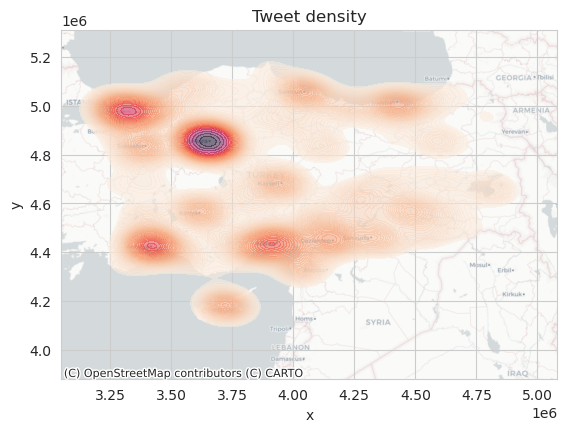

In [ ]:
# visualise a simple kde-plot
turkey_gdf = turkey_gdf.to_crs(3857)
turkey_gdf['centroid'] = turkey_gdf['geom'].centroid
turkey_gdf['x'] = turkey_gdf['centroid'].x
turkey_gdf['y'] = turkey_gdf['centroid'].y
turkey_gdf = turkey_gdf.to_crs(4326)

# then visualise the spatial tweet distribution
fig, ax = plt.subplots()
kde_plt = sns.kdeplot(x='x', y='y', data=turkey_gdf.sample(50000),
                n_levels=50, fill=True, alpha=0.55,
                cmap='rocket_r', ax=ax)
turkey_gdf.sample(1).to_crs(3857).plot(color='none', edgecolor='none', ax=ax, linewidth=0.2, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"Tweet density")

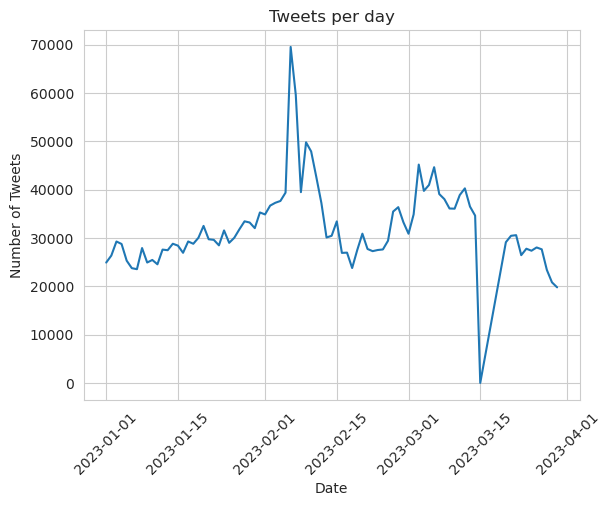

In [ ]:
# and also the temporal distribution
daily_counts: pd.DataFrame = turkey_gdf.groupby(turkey_gdf['date'].dt.date).size()

# plot the daily tweet count
ax = sns.lineplot(x=daily_counts.index, y=daily_counts.values)
ax.set_title(f"Tweets per day")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Tweets")
ax.tick_params(axis='x', rotation=45)

Lastly, let's prepare a normalised dataframe for further processing.

In [ ]:
turkey_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_tweets_merged.parquet'))

## 4. Relatedness Classification
Lastly, we need relatedness labels to create our labelling samples. The goal is to use a 66%/33% split of the classes "1" and "0" to create our samples to label.

In [3]:
turkey_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_tweets_merged.parquet'))
print(turkey_gdf.shape)
turkey_gdf.head()

(2723526, 10)


,message_id,date,text,tweet_lang,geom,photo_url,text_raw,centroid,x,y
0,1630795099385856001,2023-03-01 05:00:25,@user http,qme,"POLYGON ((4270258.414 4821568.537, 4270258.414...",http://pbs.twimg.com/media/FqG_gDNWIAAwYyv.jpg,@_ibrahimaydemir https://t.co/aTDosuMkmM,POINT (4313677.802 4849226.933),4.313678e+06,4.849227e+06
1,1630795089114005506,2023-03-01 05:00:22,🕗 Çeng-çeng! Çeng-çeng! Çeng-çeng! Çeng-çeng!...,tr,"POLYGON ((3922383.112 4430711.203, 3922383.112...",None,🕗 Çeng-çeng! Çeng-çeng! Çeng-çeng! Çeng-çeng!...,POINT (3927894.874 4439504.42),3.927895e+06,4.439504e+06
2,1630795172756832258,2023-03-01 05:00:42,Mehmet şef:DÜNYA BU KADAR,tr,"POLYGON ((3651060.889 4415987.041, 3651060.889...",None,Mehmet şef:\nDÜNYA BU KADAR,POINT (3698893.427 4470444.719),3.698893e+06,4.470445e+06
3,1630795309860175874,2023-03-01 05:01:15,"I'm at @user in Dilovası, Kocaeli http",tr,POINT (3286060.971 4978871.884),None,"I'm at @StarbucksTr in Dilovası, Kocaeli https...",POINT (3286060.971 4978871.884),3.286061e+06,4.978872e+06
4,1630795153030955009,2023-03-01 05:00:37,@user http,qme,"POLYGON ((4270258.414 4821568.537, 4270258.414...",http://pbs.twimg.com/media/FqG_jK2XwAEixC2.jpg,@MEHMETS95431584 https://t.co/aEl9Vsj1Tk,POINT (4313677.802 4849226.933),4.313678e+06,4.849227e+06


In [4]:
turkey_to_label: gpd.GeoDataFrame = build_dataset_relatedness(gdf=turkey_gdf, max_size=10000)
print(turkey_to_label.shape)
turkey_to_label.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Device set to use cuda
100%|██████████| 10000/10000 [43:24<00:00,  3.84it/s]


(10000, 13)


,level_0,index,message_id,date,text,tweet_lang,geom,photo_url,text_raw,centroid,x,y,related
0,0,2700810,1620409681406746624,2023-01-31 13:12:28,@user @user Balla didem hocam bende isterşm bo...,tr,"POLYGON ((3495717.99068 5042007.69764, 3495717...",None,@dmissdd @laviyle Balla didem hocam bende iste...,POINT (3495717.990680638 5042007.697642332),3.495718e+06,5.042008e+06,0
1,1,2700590,1620409197614747651,2023-01-31 13:10:33,D ü ş m e m e l i y i m,tr,"POLYGON ((3322611.84104 4962054.01464, 3322611...",None,D ü ş m e m e l i y i m,POINT (3331470.256496067 4969209.586992981),3.331470e+06,4.969210e+06,0
2,2,1223480,1624827067282911237,2023-02-12 17:45:35,🔴Z KUŞAĞI KATKISIYLA TUZLA’DAN 105 TIR YARDIM📌...,tr,"POLYGON ((3261329.45948 4986144.11628, 3261329...",http://pbs.twimg.com/media/FoyLlqaXgAEmBEs.jpg...,🔴Z KUŞAĞI KATKISIYLA TUZLA’DAN 105 TIR YARDIM\...,POINT (3262739.5991294663 4987581.088279095),3.262740e+06,4.987581e+06,0
3,3,1353473,1613433899010478080,2023-01-12 07:13:12,@user Geçmiş olsun canım 💐 kahveden tiksindiys...,tr,"POLYGON ((3281410.04847 4875047.09689, 3281410...",None,@mrvograk Geçmiş olsun canım 💐 kahveden tiksin...,POINT (3284940.0451783687 4878378.675905262),3.284940e+06,4.878379e+06,0
4,4,546051,1610588373550534660,2023-01-04 10:46:06,@user Güzel olduBeklenti çoktu ama Enfilasyon ...,tr,"POLYGON ((3604773.68831 4542576.95764, 3604773...",None,@leon_mrt Güzel oldu\nBeklenti çoktu ama Enfil...,POINT (3619077.241000658 4561098.71876297),3.619077e+06,4.561099e+06,0


In [7]:
turkey_to_label.groupby('related').size()

,0
related,
0,3300
1,6700


In [6]:
turkey_to_label['centroid'] = gpd.GeoSeries(turkey_to_label['centroid'], crs=3857)
turkey_to_label.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_tweets_to_label.parquet'))

Before storing the final dataframe, let's also translate the tweets to English.

In [4]:
turkey_to_label = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_tweets_to_label.parquet'))
turkey_to_label['text_en'] = translate_google(texts=turkey_to_label['text'])
turkey_to_label.head()

100%|██████████| 10000/10000 [2:33:53<00:00,  1.08it/s]


,level_0,index,message_id,date,text,tweet_lang,geom,photo_url,text_raw,centroid,x,y,related,text_en
0,0,2700810,1620409681406746624,2023-01-31 13:12:28,@user @user Balla didem hocam bende isterşm bo...,tr,"POLYGON ((3495717.99068 5042007.69764, 3495717...",None,@dmissdd @laviyle Balla didem hocam bende iste...,POINT (3495717.991 5042007.698),3.495718e+06,5.042008e+06,0,"@user @user Well, didem teacher, I also want t..."
1,1,2700590,1620409197614747651,2023-01-31 13:10:33,D ü ş m e m e l i y i m,tr,"POLYGON ((3322611.84104 4962054.01464, 3322611...",None,D ü ş m e m e l i y i m,POINT (3331470.256 4969209.587),3.331470e+06,4.969210e+06,0,D ü ş m e m e l i y i m
2,2,1223480,1624827067282911237,2023-02-12 17:45:35,🔴Z KUŞAĞI KATKISIYLA TUZLA’DAN 105 TIR YARDIM📌...,tr,"POLYGON ((3261329.45948 4986144.11628, 3261329...",http://pbs.twimg.com/media/FoyLlqaXgAEmBEs.jpg...,🔴Z KUŞAĞI KATKISIYLA TUZLA’DAN 105 TIR YARDIM\...,POINT (3262739.599 4987581.088),3.262740e+06,4.987581e+06,0,🔴105 TRUCKS OF AID FROM TUZLA WITH THE CONTRIB...
3,3,1353473,1613433899010478080,2023-01-12 07:13:12,@user Geçmiş olsun canım 💐 kahveden tiksindiys...,tr,"POLYGON ((3281410.04847 4875047.09689, 3281410...",None,@mrvograk Geçmiş olsun canım 💐 kahveden tiksin...,POINT (3284940.045 4878378.676),3.284940e+06,4.878379e+06,0,@user Get well soon my dear 💐 if you are disgu...
4,4,546051,1610588373550534660,2023-01-04 10:46:06,@user Güzel olduBeklenti çoktu ama Enfilasyon ...,tr,"POLYGON ((3604773.68831 4542576.95764, 3604773...",None,@leon_mrt Güzel oldu\nBeklenti çoktu ama Enfil...,POINT (3619077.241 4561098.719),3.619077e+06,4.561099e+06,0,"@user It was great. Expectations were high, bu..."


In [5]:
turkey_to_label.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_tweets_to_label.parquet'))